## Explaining Models with SHAP

#### Imports

In [46]:
import numpy as np
import pandas as pd
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost

#### SHAP Initialization

In [3]:
# load JS visualization code to notebook
shap.initjs()

### SHAP for Boston Dataset

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per USD 10,000
* PTRATIO - pupil-teacher ratio by town
* LSTAT - % lower status of the population
* MEDV - Median value of owner-occupied homes in $1000's

In [4]:
# train XGBoost model
X,y = shap.datasets.boston()

In [5]:
X.shape

(506, 13)

In [6]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [7]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[15:31:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[15:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_

In [8]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [9]:
shap_values.shape

(506, 13)

In [10]:
shap_values[0,:]

array([ 2.1455370e-01,  1.3466646e-03,  1.8625211e-02,  0.0000000e+00,
       -4.0719929e-01, -1.1618353e+00, -5.1294088e-02, -3.4201446e-01,
       -4.0446207e-02,  5.4874159e-03,  5.0436582e-02,  2.7335213e-02,
        3.9443178e+00], dtype=float32)

In [11]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

In [12]:
# visualize the training set predictions
# note groupings by similarity, feature value, etc.
shap.force_plot(explainer.expected_value, shap_values, X)

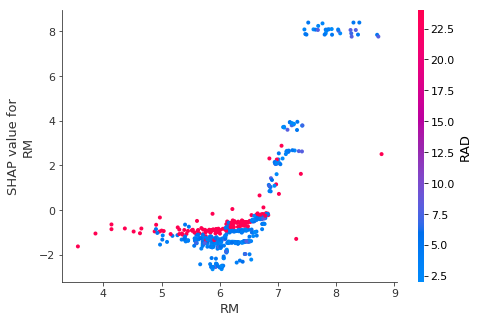

In [13]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
#
# partial dependence: understand how a single feature effects the output of the model
# plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.
#
# "Since SHAP values represent a feature's responsibility for a change in the model output, the plot
#  below represents the change in predicted house price (right axis) as RM (the average number of rooms
#  per house in an area) changes. Vertical dispersion at a single value of RM represents interaction
#  effects with other features. To help reveal these interactions dependence_plot automatically selects
#  another feature for coloring. In this case coloring by RAD (index of accessibility to radial highways)
#  highlights that the average number of rooms per house has less impact on home price for areas with
#  a high RAD value."
#
shap.dependence_plot("RM", shap_values, X)

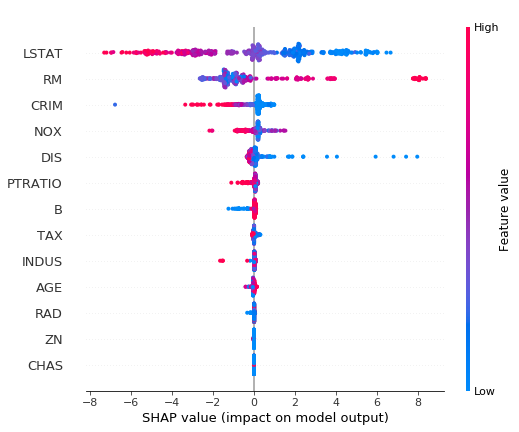

In [14]:
# summarize the effects of all the features
# note high LSTAT lowers the predicted home price
shap.summary_plot(shap_values, X)

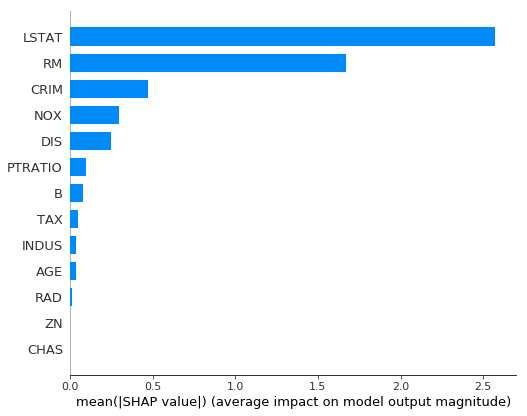

In [15]:
# mean absolute value of the SHAP values for each feature
shap.summary_plot(shap_values, X, plot_type="bar")

### SHAP for Absenteeism Model

In [16]:
pwd

'C:\\Users\\t0272m1\\Projects\\HR Analytics'

In [17]:
path = 'C:/Users/t0272m1/Projects/HR Analytics/input/'

In [18]:
train_file = '\\'.join([path, 'train.csv'])
df_train = pd.read_csv(train_file)

In [19]:
test_file = '\\'.join([path, 'test.csv'])
df_test = pd.read_csv(test_file)

In [20]:
df_train.shape, df_test.shape

((8990, 47), (4429, 47))

#### Exploratory

In [21]:
for f in df_train.columns:
    print(f, df_train[f].dtype)

group_total_cid float64
lost_hours float64
actual_hours float64
paa_hours float64
absences_late float64
absences_noshow float64
absences_any float64
mean_absence_pct float64
mean_experience float64
absences_planned float64
home_canvasses float64
absences_fmla float64
peia_count float64
tpt_count float64
streak_1 float64
streak_2 float64
streak_3 float64
streak_4_plus float64
cluster float64
group_total float64
tpt_unplanned float64
tpt_extra float64
absences_unplanned_rolling_sum_5 float64
absences_unplanned_rolling_median_5 float64
absences_unplanned_rolling_sum_12 float64
absences_unplanned_rolling_median_12 float64
absences_unplanned_rolling_sum_20 float64
absences_unplanned_rolling_median_20 float64
actual_hours_rolling_mean_20 float64
actual_hours_rolling_median_20 float64
lost_hours_rolling_mean_20 float64
lost_hours_rolling_median_20 float64
kp_residual_5 float64
kp_residual_12 float64
kp_residual_20 float64
year int64
quarter int64
month int64
week int64
day int64
day_of_week i

In [22]:
df_train.columns

Index(['group_total_cid', 'lost_hours', 'actual_hours', 'paa_hours',
       'absences_late', 'absences_noshow', 'absences_any', 'mean_absence_pct',
       'mean_experience', 'absences_planned', 'home_canvasses',
       'absences_fmla', 'peia_count', 'tpt_count', 'streak_1', 'streak_2',
       'streak_3', 'streak_4_plus', 'cluster', 'group_total', 'tpt_unplanned',
       'tpt_extra', 'absences_unplanned_rolling_sum_5',
       'absences_unplanned_rolling_median_5',
       'absences_unplanned_rolling_sum_12',
       'absences_unplanned_rolling_median_12',
       'absences_unplanned_rolling_sum_20',
       'absences_unplanned_rolling_median_20', 'actual_hours_rolling_mean_20',
       'actual_hours_rolling_median_20', 'lost_hours_rolling_mean_20',
       'lost_hours_rolling_median_20', 'kp_residual_5', 'kp_residual_12',
       'kp_residual_20', 'year', 'quarter', 'month', 'week', 'day',
       'day_of_week', 'day_of_year', 'nth_kday', 'next_day_delta',
       'crew_factor', 'production_line

##### Select features

In [27]:
cols_select = ['crew_factor',
               'production_line_factor',
               'lost_hours',
               'actual_hours',
               'absences_unplanned_rolling_median_5',
               'absences_unplanned_rolling_median_12',
               'absences_unplanned_rolling_median_20',
               'month',
               'day_of_week',
               'absences_unplanned']
df_train = df_train[cols_select]
df_test = df_test[cols_select]

In [28]:
df_train.columns

Index(['crew_factor', 'production_line_factor', 'lost_hours', 'actual_hours',
       'absences_unplanned_rolling_median_5',
       'absences_unplanned_rolling_median_12',
       'absences_unplanned_rolling_median_20', 'month', 'day_of_week',
       'absences_unplanned'],
      dtype='object')

#### XGBoost Training

In [29]:
target = 'absences_unplanned'
y_train = df_train[target]
y_test = df_test[target]
df_train.drop(columns=[target], inplace=True)
df_test.drop(columns=[target], inplace=True)

E:\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [30]:
# train XGBoost model
bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(df_train, label=y_train), 100)

[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned no

[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

In [31]:
bst

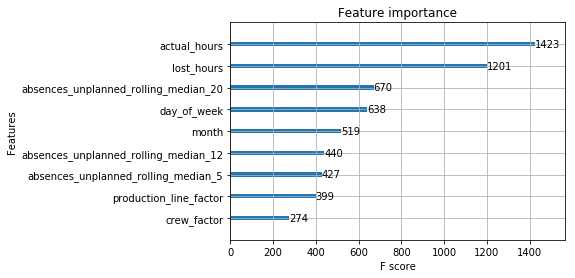

In [32]:
xgboost.plot_importance(bst)

#### XGBoost Testing

In [33]:
ypred = bst.predict(xgboost.DMatrix(df_test))

In [34]:
max(ypred)

10.569021

#### SHAP

In [35]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(df_train, label=y_train), 100)

[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[15:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned no

[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[15:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned no

In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_train)

In [39]:
# visualize a prediction's explanation
shap_index = 500
shap.force_plot(explainer.expected_value, shap_values[shap_index,:], df_train.iloc[shap_index,:])

In [40]:
# visualize another prediction's explanation
shap_index = 1000
shap.force_plot(explainer.expected_value, shap_values[shap_index,:], df_train.iloc[shap_index,:])

In [41]:
# note original sample ordering because of the time series
slice_start = 4000
slice_end = 4500
shap.force_plot(explainer.expected_value, shap_values[slice_start:slice_end], df_train[slice_start:slice_end])

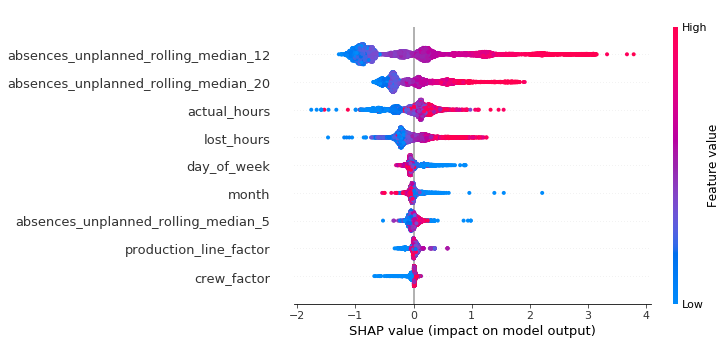

In [42]:
# summarize the effects of all the features
# note inverse day of week
shap.summary_plot(shap_values, df_train)

#### Kernel Explainer

"Kernel SHAP uses a specially-weighted local linear regression to estimate SHAP values for any model. Below is a simple example for explaining a multi-class SVM on the classic iris dataset."

In [48]:
import warnings
warnings.filterwarnings("ignore")

# train a SVM classifier
X_train, X_test, Y_train, Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 120 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 30/30 [00:00<00:00, 79.78it/s]


In [49]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")